# 課題1

In [51]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def getKeyResponse(GazeDataFrame):
    tmp = GazeDataFrame[GazeDataFrame['Event'].isin(['KeyboardEvent'])]
    Response = tmp[1:16][tmp['Event value'] != 'space']['Event value'].values
    return Response

tmp = pd.read_table("./Class_EyeTracking/CorrectAnswer.csv")
Correct = tmp['Correct Answer'].values

ID_list = [f'ID{i:03d}' for i in range(20)] + [f'ID{i:03d}' for i in range(101, 106)]

result_dfs = []  # 各IDごとの結果を格納するためのリスト

for i in ID_list:
    # csvファイルをロード
    df = pd.read_csv(f"./Class_EyeTracking/data/{i}_DataExport.csv")
    
    # getKeyResponse関数で 'Response' 列を生成
    Response = getKeyResponse(df)

    # Hit, False Alarm, Miss, Correct Rejectionの計算
    TP = sum((Response == 'Right') & (Correct == 'Right'))
    FP = sum((Response == 'Right') & (Correct == 'Left'))
    FN = sum((Response == 'Left') & (Correct == 'Right'))
    TN = sum((Response == 'Left') & (Correct == 'Left'))

    # 評価指標の計算
    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    F = (2 * Precision * Recall) / (Precision + Recall)
    KeyMiss = 15 - TP - FP - FN - TN

    # 結果のDataFrameを作成
    result_df = pd.DataFrame({
        'ID': i[2:],
        'Accuracy': [Accuracy],
        'Precision': [Precision],
        'Recall': [Recall],
        "F-measure": [F],
        'TP': [TP],
        'FN': [FN],
        'FP': [FP],
        'TN': [TN],
        'KeyMiss': [KeyMiss]
    })

    # 結果をリストに追加
    result_dfs.append(result_df)

# 全ての結果を1つのDataFrameに結合
final_result_df = pd.concat(result_dfs, ignore_index=True)
final_result_df.to_csv("kadai1.csv", index=False)

# 結果のDataFrameを表示
final_result_df

,ID,Accuracy,Precision,Recall,F-measure,TP,FN,FP,TN,KeyMiss
0,000,1.000000,1.000000,1.000000,1.000000,10,0,0,4,1
1,001,0.866667,0.833333,1.000000,0.909091,10,0,2,3,0
2,002,0.600000,0.833333,0.500000,0.625000,5,5,1,4,0
3,003,0.666667,0.857143,0.600000,0.705882,6,4,1,4,0
4,004,0.866667,0.900000,0.900000,0.900000,9,1,1,4,0
5,005,0.933333,1.000000,0.900000,0.947368,9,1,0,5,0
6,006,0.600000,0.833333,0.500000,0.625000,5,5,1,4,0
7,007,1.000000,1.000000,1.000000,1.000000,10,0,0,5,0
8,008,0.800000,1.000000,0.700000,0.823529,7,3,0,5,0
9,009,0.800000,1.000000,0.700000,0.823529,7,3,0,5,0


# 課題2 TOI

In [20]:
# ライブラリインポート
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

ID_list = [f'ID{i:03d}' for i in range(20)] + [f'ID{i:03d}' for i in range(101, 106)]
stimuli_list = ['01_Kyoumu_T.png', '02_Amazon2_F.png', '03_Amazon3_F.png',
                '04_Rakuten2_F.png', '05_ticket_T.png', '06_Rakuten_F.png',
                '07_Rakuten_T.png', '08_yodobasi_F.png', '09_Apple1_F.png',
                '10_Kankou_T.png', '11_LINE_F.png', '12_Kyufu2_F.png',
                '13_ponta_T.png', '14_Kyufu_F.png', '15_SMBC_F.png']

result_data = {'ID': ID_list}

def getTOI(GazeDataFrame, MediaName):
    TOI = GazeDataFrame[GazeDataFrame['Presented Media name'].isin([MediaName])]
    return TOI

for MediaName in stimuli_list:
    durations = []
    for ID in ID_list:
        df = pd.read_csv(f"./Class_EyeTracking/data/{ID}_DataExport.csv")  # Experiment data path
        TOI = getTOI(df, MediaName)

        if not TOI.empty:
            TOI_start = TOI['Recording timestamp'].iloc[1]
            TOI_end = TOI['Recording timestamp'].iloc[-1]
            Duration = (TOI_end - TOI_start) / 1000000
            durations.append(Duration)
        else:
            durations.append(None)

    result_data[MediaName] = durations

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame(result_data)

# 各IDの平均持続時間を計算
result_df['Mean Duration'] = result_df.iloc[:, 1:].mean(axis=1)

# 最大および最小の平均持続時間を持つIDを見つける
max_mean_duration_ID = result_df.loc[result_df['Mean Duration'].idxmax()]['ID']
min_mean_duration_ID = result_df.loc[result_df['Mean Duration'].idxmin()]['ID']
max_mean_duration = result_df['Mean Duration'].max()
min_mean_duration = result_df['Mean Duration'].min()

# 結果を表示
print("平均TOI持続時間が最大のID:")
print("ID:", max_mean_duration_ID, "- 平均持続時間:", max_mean_duration)
print("\n平均TOI持続時間が最小のID:")
print("ID:", min_mean_duration_ID, "- 平均持続時間:", min_mean_duration)

duration_list = ['min', 'max']

for duration_type in duration_list:
    for MediaName in stimuli_list:
        #----- 被験者応答読み込み
        ID = max_mean_duration_ID if duration_type == 'max' else min_mean_duration_ID

        # csvファイルをロード
        df = pd.read_csv("./Class_EyeTracking/data/" + ID + "_DataExport.csv") #実験データへのパス

        # TOI抽出
        TOI = getTOI(df, MediaName)

        # 視線位置の X, Y を取得。この値を使ってプロットする。
        GazeX = TOI['Gaze point X']
        GazeY = TOI['Gaze point Y']

        # 刺激画像の読み込み;
        img_bgr = cv2.imread('./Class_EyeTracking/stimuli/' + MediaName[:-4] + '_Stim.png')
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # 画像の高さと幅を取得
        img_height, img_width, _ = img.shape

        # 画像内に収まるように視線位置をクリップ
        GazeX = GazeX.clip(0, img_width - 1)
        GazeY = GazeY.clip(0, img_height - 1)

        # 画像の表示
        plt.figure()
        plt.imshow(img)
        plt.plot(GazeX, GazeY, 'r.-')
        # タイトルを追加
        plt.title("Line of sight for {} - ID: {}".format(MediaName, ID[2:]))

        png_output_folder = f'./課題2/{ID}/gaze/png/'
        os.makedirs(png_output_folder, exist_ok=True)
        filename = png_output_folder + ID + '_gaze_' + MediaName
        plt.savefig(filename[:-4] + '.png')

        svg_output_folder = f'./課題2/{ID}/gaze/svg/'
        os.makedirs(svg_output_folder, exist_ok=True)
        filename = svg_output_folder + ID + '_gaze_' + MediaName
        plt.savefig(filename[:-4] + '.svg')

        eps_output_folder = f'./課題2/{ID}/gaze/eps/'
        os.makedirs(eps_output_folder, exist_ok=True)
        filename = eps_output_folder + ID + '_gaze_' + MediaName
        plt.savefig(filename[:-4] + '.eps')
        plt.close()

        
        # 1. ----- 画像配列初期化
        imSize = img.shape
        heatmap = np.zeros([imSize[0], imSize[1]], dtype='float32')

        # イメージのサイズを取得
        image_height, image_width = imSize[:2]

        # 2.～4. ----- 視線位置が記録された画素をインクリメント
        for i in range(len(GazeX)):
            # 視線位置が記録されていれば処理（Eyes Not Found の場合もあるので。）
            if not (np.isnan(GazeX.iloc[i]) or np.isnan(GazeY.iloc[i])):
                # インデックスが画像サイズを超えないように制約
                xx = min(int(GazeX.iloc[i]), image_width - 1)
                yy = min(int(GazeY.iloc[i]), image_height - 1)
                heatmap[yy, xx] = heatmap[yy, xx] + 1

        # 5. ----- ぼかしを適用
        # 標準偏差=50pixのガウス分布を使用
        # ガウス分布が0に漸近するのに十分なカーネルサイズを指定; 標準偏差の4倍あればOK
        heatmap_blur = cv2.GaussianBlur(heatmap, (201,201), 50)
        # 画像を 0-1 に正規化
        MAX = np.max(heatmap_blur)  # 最大値
        MIN = np.min(heatmap_blur)  # 最小値
        heatmap_blur = (heatmap_blur - MIN)/(MAX - MIN) # 正規化

        #----- 表示するための作業
        # ヒートマップをRGBに変換
        heatmap_rgb = np.uint8(255 * heatmap_blur)
        # JETのカラーマップを適用
        heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)
        # RGBに変換
        heatmap_rgb = cv2.cvtColor(heatmap_rgb, cv2.COLOR_BGR2RGB)

        superimposed_img = heatmap_rgb*0.4 + img
        superimposed_img = superimposed_img/np.max(superimposed_img)

        # 画像を表示
        fig = plt.figure()
        # タイトルを追加
        plt.title("Heatmap for {} - ID: {}".format(MediaName, ID[2:]))
        plt.imshow(superimposed_img)

        # 保存
        png_output_folder = f'./課題2/{ID}/heatmap/png/'
        os.makedirs(png_output_folder, exist_ok=True)
        filename = png_output_folder + ID + '_heatmap_' + MediaName
        plt.savefig(filename[:-4] + '.png')

        svg_output_folder = f'./課題2/{ID}/heatmap/svg/'
        os.makedirs(svg_output_folder, exist_ok=True)
        filename = svg_output_folder + ID + '_heatmap_' + MediaName
        plt.savefig(filename[:-4] + '.svg')

        eps_output_folder = f'./課題2/{ID}/heatmap/eps/'
        os.makedirs(eps_output_folder, exist_ok=True)
        filename = eps_output_folder + ID + '_heatmap_' + MediaName
        plt.savefig(filename[:-4] + '.eps')
        plt.close()

result_df.to_csv("ToI.csv", index=False, float_format='%.4f')
result_df

平均TOI持続時間が最大のID:
ID: ID015 - 平均持続時間: 56.405265666666665

平均TOI持続時間が最小のID:
ID: ID010 - 平均持続時間: 1.9466761333333336


,ID,01_Kyoumu_T.png,02_Amazon2_F.png,03_Amazon3_F.png,04_Rakuten2_F.png,05_ticket_T.png,06_Rakuten_F.png,07_Rakuten_T.png,08_yodobasi_F.png,09_Apple1_F.png,10_Kankou_T.png,11_LINE_F.png,12_Kyufu2_F.png,13_ponta_T.png,14_Kyufu_F.png,15_SMBC_F.png,Mean Duration
0,ID000,6.633282,10.216574,5.583660,6.999929,5.533282,10.033595,9.116590,7.833262,7.433271,9.866582,6.616978,12.383224,10.050316,7.233343,9.383233,8.327808
1,ID001,14.883203,7.849935,8.183259,7.483626,9.916563,10.300269,17.799830,16.366509,10.733593,11.399902,13.116915,13.383212,18.583225,13.500235,7.649920,12.076680
2,ID002,9.799865,9.816524,2.699963,15.767044,6.933258,7.116640,13.883412,11.966543,13.916866,9.583249,10.283250,9.399913,11.849882,11.483384,11.433229,10.395535
3,ID003,15.217012,30.716489,3.416631,19.949939,11.283942,2.716644,36.216285,9.900303,3.683504,14.766515,13.549879,7.516900,18.083485,16.116535,10.600275,14.248956
4,ID004,40.016854,32.400183,22.400090,28.066825,56.366987,38.716875,41.033541,21.283443,24.150170,35.516866,12.150093,36.158540,35.458526,23.866802,31.933512,31.967954
5,ID005,27.416806,24.300139,7.966655,13.850090,11.533411,23.083456,5.650042,7.533388,8.783370,15.166714,25.016791,35.916883,13.000047,24.383436,27.566795,18.077868
6,ID006,23.466827,26.816824,11.633393,18.000101,25.750121,15.816777,19.816749,11.850069,5.400038,25.483450,4.566700,8.666740,9.350069,16.066770,11.050033,15.582311
7,ID007,22.033461,4.300034,11.350059,21.083504,31.283526,31.883527,27.750163,6.316714,4.733369,36.750164,8.983410,21.200130,25.766856,12.433430,17.033474,18.860121
8,ID008,23.650122,13.783415,15.183406,22.016829,19.466789,24.816808,24.483486,18.816803,14.266711,17.683428,9.850070,20.116804,22.083462,10.866705,21.816829,18.593444
9,ID009,6.300018,4.066684,7.250046,11.866707,9.250039,11.900043,27.483446,14.166705,14.416714,19.716726,6.550021,27.916777,18.316733,16.233385,9.433382,13.657828


## 全画像出力コード

In [19]:
import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

ID_list = [f'ID{i:03d}' for i in range(20)] + [f'ID{i:03d}' for i in range(101, 106)]
stimuli_list = ['01_Kyoumu_T.png', '02_Amazon2_F.png', '03_Amazon3_F.png', '04_Rakuten2_F.png',
                '05_ticket_T.png', '06_Rakuten_F.png', '07_Rakuten_T.png', '08_yodobasi_F.png',
                '09_Apple1_F.png', '10_Kankou_T.png', '11_LINE_F.png', '12_Kyufu2_F.png',
                '13_ponta_T.png', '14_Kyufu_F.png', '15_SMBC_F.png']

result_data = {'ID': ID_list}

def getTOI(GazeDataFrame, MediaName):
    TOI = GazeDataFrame[GazeDataFrame['Presented Media name'].isin([MediaName])]
    return TOI

for MediaName in stimuli_list:
    durations = []
    for ID in ID_list:
        df = pd.read_csv(f"./Class_EyeTracking/data/{ID}_DataExport.csv")
        TOI = getTOI(df, MediaName)

        if not TOI.empty:
            TOI_start = TOI['Recording timestamp'].iloc[1]
            TOI_end = TOI['Recording timestamp'].iloc[-1]
            Duration = (TOI_end - TOI_start) / 1000000
            durations.append(Duration)
        else:
            durations.append(None)

    result_data[MediaName] = durations

result_df = pd.DataFrame(result_data)


for MediaName in stimuli_list:
    durations = []
    for ID in ID_list:
        df = pd.read_csv(f"./Class_EyeTracking/data/{ID}_DataExport.csv")
        TOI = getTOI(df, MediaName)

        if not TOI.empty:
            TOI_start = TOI['Recording timestamp'].iloc[1]
            TOI_end = TOI['Recording timestamp'].iloc[-1]
            Duration = (TOI_end - TOI_start) / 1000000
            durations.append(Duration)
        else:
            durations.append(None)

        #----- 被験者応答読み込み

        # csvファイルをロード
        df = pd.read_csv("./Class_EyeTracking/data/" + ID + "_DataExport.csv") #実験データへのパス

        # TOI抽出
        TOI = getTOI(df, MediaName)

        # 視線位置の X, Y を取得。この値を使ってプロットする。
        GazeX = TOI['Gaze point X']
        GazeY = TOI['Gaze point Y']

        # 刺激画像の読み込み;
        img_bgr = cv2.imread('./Class_EyeTracking/stimuli/' + MediaName[:-4] + '_Stim.png')
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # 画像の高さと幅を取得
        img_height, img_width, _ = img.shape

        # 画像内に収まるように視線位置をクリップ
        GazeX = GazeX.clip(0, img_width - 1)
        GazeY = GazeY.clip(0, img_height - 1)

        # 画像の表示
        plt.figure()
        plt.imshow(img)
        plt.plot(GazeX, GazeY, 'r.-')
        # タイトルを追加
        plt.title("Line of sight for {} - ID: {}".format(MediaName, ID[2:]))

        png_output_folder = f'./課題2_all/{ID}/gaze/png/'
        os.makedirs(png_output_folder, exist_ok=True)
        filename = png_output_folder + ID + '_gaze_' + MediaName
        plt.savefig(filename[:-4] + '.png')

        svg_output_folder = f'./課題2_all/{ID}/gaze/svg/'
        os.makedirs(svg_output_folder, exist_ok=True)
        filename = svg_output_folder + ID + '_gaze_' + MediaName
        plt.savefig(filename[:-4] + '.svg')
        plt.close()

        
        # 1. ----- 画像配列初期化
        imSize = img.shape
        heatmap = np.zeros([imSize[0], imSize[1]], dtype='float32')

        # イメージのサイズを取得
        image_height, image_width = imSize[:2]

        # 2.～4. ----- 視線位置が記録された画素をインクリメント
        for i in range(len(GazeX)):
            # 視線位置が記録されていれば処理（Eyes Not Found の場合もあるので。）
            if not (np.isnan(GazeX.iloc[i]) or np.isnan(GazeY.iloc[i])):
                # インデックスが画像サイズを超えないように制約
                xx = min(int(GazeX.iloc[i]), image_width - 1)
                yy = min(int(GazeY.iloc[i]), image_height - 1)
                heatmap[yy, xx] = heatmap[yy, xx] + 1

        # 5. ----- ぼかしを適用
        # 標準偏差=50pixのガウス分布を使用
        # ガウス分布が0に漸近するのに十分なカーネルサイズを指定; 標準偏差の4倍あればOK
        heatmap_blur = cv2.GaussianBlur(heatmap, (201,201), 50)
        # 画像を 0-1 に正規化
        MAX = np.max(heatmap_blur)  # 最大値
        MIN = np.min(heatmap_blur)  # 最小値
        heatmap_blur = (heatmap_blur - MIN)/(MAX - MIN) # 正規化

        #----- 表示するための作業
        # ヒートマップをRGBに変換
        heatmap_rgb = np.uint8(255 * heatmap_blur)
        # JETのカラーマップを適用
        heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)
        # RGBに変換
        heatmap_rgb = cv2.cvtColor(heatmap_rgb, cv2.COLOR_BGR2RGB)

        superimposed_img = heatmap_rgb*0.4 + img
        superimposed_img = superimposed_img/np.max(superimposed_img)

        # 画像を表示
        fig = plt.figure()
        # タイトルを追加
        plt.title("Heatmap for {} - ID: {}".format(MediaName, ID[2:]))
        plt.imshow(superimposed_img)

        # 保存
        png_output_folder = f'./課題2_all/{ID}/heatmap/png/'
        os.makedirs(png_output_folder, exist_ok=True)
        filename = png_output_folder + ID + '_heatmap_' + MediaName
        plt.savefig(filename[:-4] + '.png')

        svg_output_folder = f'./課題2_all/{ID}/heatmap/svg/'
        os.makedirs(svg_output_folder, exist_ok=True)
        filename = svg_output_folder + ID + '_heatmap_' + MediaName
        plt.savefig(filename[:-4] + '.svg')
        eps_output_folder = f'./課題2_all/{ID}/heatmap/eps/'
        os.makedirs(eps_output_folder, exist_ok=True)
        filename = eps_output_folder + ID + '_heatmap_' + MediaName
        plt.savefig(filename[:-4] + '.eps')
    
        plt.close()

/var/folders/q6/2n29b4z536b3z21tdhs1trbm0000gn/T/ipykernel_53089/190099128.py:118: RuntimeWarning: invalid value encountered in divide
  heatmap_blur = (heatmap_blur - MIN)/(MAX - MIN) # 正規化
/var/folders/q6/2n29b4z536b3z21tdhs1trbm0000gn/T/ipykernel_53089/190099128.py:122: RuntimeWarning: invalid value encountered in cast
  heatmap_rgb = np.uint8(255 * heatmap_blur)
/var/folders/q6/2n29b4z536b3z21tdhs1trbm0000gn/T/ipykernel_53089/190099128.py:118: RuntimeWarning: invalid value encountered in divide
  heatmap_blur = (heatmap_blur - MIN)/(MAX - MIN) # 正規化
/var/folders/q6/2n29b4z536b3z21tdhs1trbm0000gn/T/ipykernel_53089/190099128.py:122: RuntimeWarning: invalid value encountered in cast
  heatmap_rgb = np.uint8(255 * heatmap_blur)
/var/folders/q6/2n29b4z536b3z21tdhs1trbm0000gn/T/ipykernel_53089/190099128.py:118: RuntimeWarning: invalid value encountered in divide
  heatmap_blur = (heatmap_blur - MIN)/(MAX - MIN) # 正規化
/var/folders/q6/2n29b4z536b3z21tdhs1trbm0000gn/T/ipykernel_53089/190099

# 課題3 AOI

In [8]:
# 課題3：被験者1名のAOI時間を、画像刺激間で平均する。
import os
import pandas as pd
import numpy as np

ID_list = [f'ID{i:03d}' for i in range(20)] + [f'ID{i:03d}' for i in range(101, 106)]

for ID in ID_list:
    ID = ID
    raw = pd.read_table('./Class_EyeTracking/Metrics/' + ID + '_Metrics.tsv')

    cutLabels = []  # 抽出するデータラベルを保存するリスト
    for label in raw.columns:
        # if文で特定の文字列を含む列を抽出
        if label.find('Total_duration_of_fixations') \
            != -1 or label.find('Duration_of_interval') \
                != -1 or label.find('TOI') != -1:
            cutLabels.append(label)  # リストに追加

    # データを抽出
    df = raw[cutLabels]

    NUM = 15  # 呈示刺激の数; 今回は 15なので 15+1=16
    TOI = raw['TOI'].iloc[0:NUM]  # TOIを初期化; rawデータから引っ張ってくる
    res = np.zeros([NUM, 4])

    # 'Total_duration_of_fixations'が含まれる列を抽出
    total_fixations_columns = [col for col in df.columns \
                            if 'Total_duration_of_fixations' in col]

    # 各列の合計を計算
    total_fixations = df[total_fixations_columns].sum(axis=1)

    # TOIでloop 処理
    for i in range(NUM):
        # 計算用変数の初期化
        Header = 0
        HeaderTime = 0
        Footer = 0
        URL = 0

        tmp = df[i:i + 1].dropna(how="all", axis=1)  # 欠損値（NaN）を含むデータラベルを除外
        #TOTAL = np.array(total_fixations.iloc[i])  # 'Total_duration_of_fixations'列の値をTOTALに変更
        TOTAL = np.array(tmp['Duration_of_interval'].values)

        # データラベルで loop 処理
        for label in tmp.columns:
            # データラベルが Header で終わる列を抽出
            if label.endswith('Header') == 1:
                Header += tmp[label].values
            # データラベルが HeaderTime で終わる列を抽出
            if label.endswith('HeaderTime') == 1:
                HeaderTime += tmp[label].values
            # データラベルが Footer で終わる列を抽出
            if label.endswith('Footer'):
                Footer += tmp[label].values
            # データラベルに URL を含む列を抽出
            if label.find('URL') != -1:
                URL += tmp[label].values

        # 結果を格納
        Header = np.array(Header)
        HeaderTime = np.array(HeaderTime)
        Footer = np.array(Footer)
        URL = np.array(URL)

        # 各変数を正規化してから結合
        calc = np.column_stack([Header, HeaderTime, Footer, URL]) / TOTAL[:, np.newaxis]
        res[i, :] = calc[0]

    # DataFrame として統合
    df_sum = pd.DataFrame(res,
                        columns=['Header', 'HeaderTime', 'Footer', 'URL'],
                        index=TOI)
    # 出力ディレクトリの指定
    output_directory = 'AOI/'

    # ファイル名の生成
    csv_filename = f"{ID}_AOI.csv"

    # 完全なファイルパスの生成
    output_filepath = os.path.join(output_directory, csv_filename)
    os.makedirs(output_directory, exist_ok=True)

    # CSVファイルに出力
    df_sum.to_csv(output_filepath, index=False)
    

In [17]:
import pandas as pd

# 被験者のIDリスト
ID_list = [f'ID{i:03d}' for i in range(20)] + [f'ID{i:03d}' for i in range(101, 106)]

# 各被験者のデータを格納するリスト
data_frames = []

# 各被験者のCSVファイルを読み込んでリストに追加
for i in ID_list:
    # CSVファイルをロード
    df = pd.read_csv(f"./AOI/{i}_AOI.csv")

    # 値が0の場合をNaNに変換
    df.replace(0, pd.NA, inplace=True)
    
    # 平均値を計算して新しい行として追加
    df_mean = df.mean().to_frame().transpose()
    df_mean.insert(0, 'ID', i[2:])  # IDを一番左に挿入
    
    # リストに追加
    data_frames.append(df_mean)

# データフレームを作成
df_result = pd.concat(data_frames, ignore_index=True)

# NaNを0に変換
df_result = df_result.fillna(0)

# 二つのCSVファイルを読み込む
df1 = pd.read_csv('kadai1.csv', dtype={'ID': str})
df2 = df_result

# df2から 'ID' 列を除外
df2_without_id = df2.drop(columns=['ID'])


# データフレームを横に結合（横に並べる）
result = pd.concat([df1, df2_without_id], axis=1)

result.to_csv("results_example.csv", index=False, float_format='%.4f')
result

,ID,Accuracy,Precision,Recall,F-measure,TP,FN,FP,TN,KeyMiss,Header,HeaderTime,Footer,URL
0,000,1.000000,1.000000,1.000000,1.000000,10,0,0,4,1,0.160952,0.117975,0.162857,0.065473
1,001,0.866667,0.833333,1.000000,0.909091,10,0,2,3,0,0.335801,0.055553,0.065987,0.078476
2,002,0.600000,0.833333,0.500000,0.625000,5,5,1,4,0,0.112852,0.061439,0.000000,0.054247
3,003,0.666667,0.857143,0.600000,0.705882,6,4,1,4,0,0.000000,0.000000,0.000000,0.000000
4,004,0.866667,0.900000,0.900000,0.900000,9,1,1,4,0,0.073922,0.012401,0.048618,0.053351
5,005,0.933333,1.000000,0.900000,0.947368,9,1,0,5,0,0.142779,0.013009,0.159771,0.081917
6,006,0.600000,0.833333,0.500000,0.625000,5,5,1,4,0,0.089529,0.018759,0.191628,0.103624
7,007,1.000000,1.000000,1.000000,1.000000,10,0,0,5,0,0.296993,0.010714,0.077579,0.140345
8,008,0.800000,1.000000,0.700000,0.823529,7,3,0,5,0,0.126098,0.024971,0.132417,0.095367
9,009,0.800000,1.000000,0.700000,0.823529,7,3,0,5,0,0.205916,0.036772,0.000000,0.083838


# 課題4 相関解析

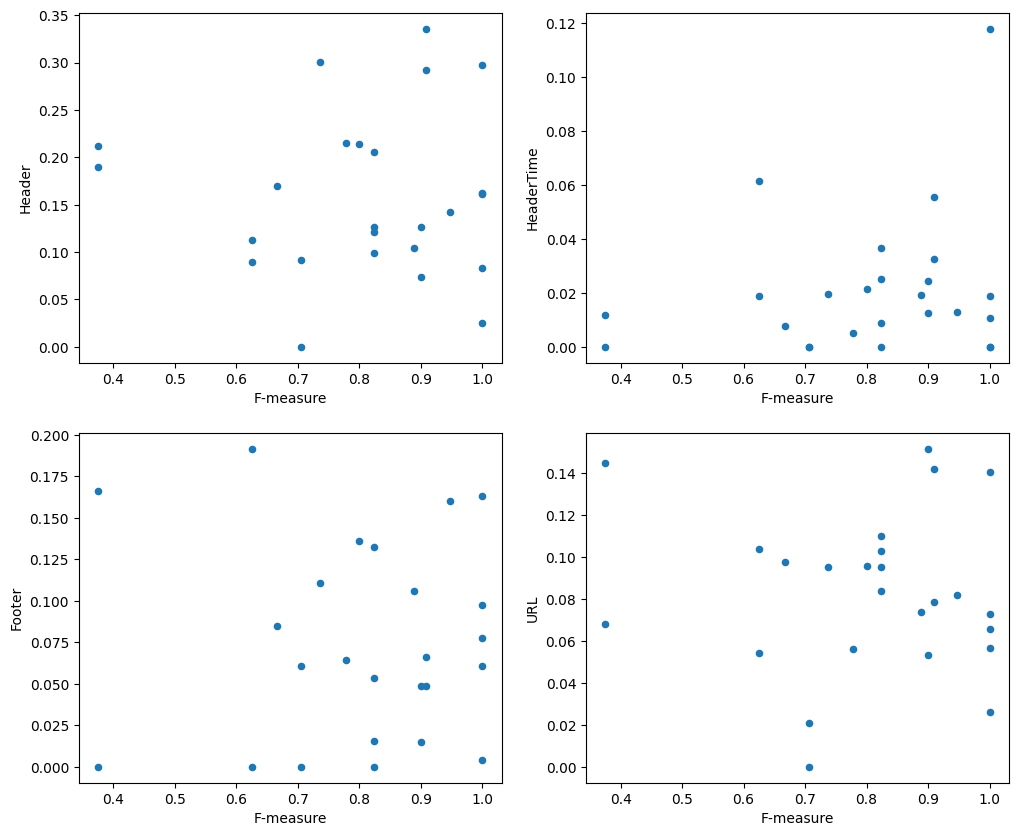

,ID,Accuracy,Precision,Recall,F-measure,TP,FN,FP,TN,KeyMiss,Header,HeaderTime,Footer,URL
ID,1.000000,0.166634,0.218947,0.098074,0.158459,0.102717,-0.095603,-0.256264,0.291350,-0.173373,-0.305343,-0.357890,-0.296175,-0.072542
Accuracy,0.166634,1.000000,0.830919,0.949225,0.996268,0.942872,-0.951131,-0.704613,0.661975,0.182260,-0.045472,0.216852,0.002170,-0.048297
Precision,0.218947,0.830919,1.000000,0.626035,0.809088,0.613273,-0.631607,-0.951976,0.933469,0.211255,-0.240933,0.107020,0.022685,-0.107542
Recall,0.098074,0.949225,0.626035,1.000000,0.962519,0.998201,-0.999545,-0.445724,0.401357,0.118325,0.109889,0.256091,-0.027355,0.005589
F-measure,0.158459,0.996268,0.809088,0.962519,1.000000,0.956820,-0.964078,-0.663983,0.624129,0.161985,-0.016678,0.216759,-0.011309,-0.045865
TP,0.102717,0.942872,0.613273,0.998201,0.956820,1.000000,-0.995938,-0.433079,0.388346,0.075958,0.101028,0.254151,-0.040265,0.001284
FN,-0.095603,-0.951131,-0.631607,-0.999545,-0.964078,-0.995938,1.000000,0.451482,-0.407360,-0.139490,-0.114200,-0.256719,0.020820,-0.007748
FP,-0.256264,-0.704613,-0.951976,-0.445724,-0.663983,-0.433079,0.451482,1.000000,-0.978533,-0.235920,0.383407,-0.038415,-0.063184,0.152712
TN,0.291350,0.661975,0.933469,0.401357,0.624129,0.388346,-0.407360,-0.978533,1.000000,0.094304,-0.389692,-0.123755,-0.001150,-0.135011
KeyMiss,-0.173373,0.182260,0.211255,0.118325,0.161985,0.075958,-0.139490,-0.235920,0.094304,1.000000,0.103061,0.566231,0.382399,-0.016591


In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルからデータフレームを読み込む
df = pd.read_csv('results_example.csv')

# 横軸を F値、縦軸をAOIにしてプロット
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# 散布図を作成
df.plot.scatter('F-measure', 'Header', ax=axes[0, 0])
df.plot.scatter('F-measure', 'HeaderTime', ax=axes[0, 1])
df.plot.scatter('F-measure', 'Footer', ax=axes[1, 0])
df.plot.scatter('F-measure', 'URL', ax=axes[1, 1])

# 相関係数の算出
correlation_matrix = df.corr()

# グラフを保存
output_folder = './課題4/'
os.makedirs(output_folder, exist_ok=True)
fig.savefig(os.path.join(output_folder, 'scatter_plots.svg'))
fig.savefig(os.path.join(output_folder, 'scatter_plots.png'))

# 相関係数をCSVファイルとして保存
correlation_matrix.to_csv(os.path.join(output_folder, 'correlation_matrix.csv'), index=True, float_format='%.4f')

# 表示
plt.show()

# 相関係数を表示
df.corr()
